# Probing folk wisdom

## Setup

In [1]:
# !jupyter nbconvert --to script probe-folk.ipynb

In [4]:
'Notebooks is ready.'

'Notebooks is ready.'

In [5]:
%load_ext autoreload
%autoreload 2
import os
import pickle
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import sys
sys.path.insert(0, os.path.abspath('../..'))
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import collections
import pandas as pd
import random
import nltk
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')  # temporary, not recommended
import kaleido

import utils.references as refs
from utils.acts_util import normalize, spherize
from utils.context_util import abbreviated_context as context_txt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# load corpus and acts
corpus_dir = '/atlas/u/pkalluri/bert-vis/big-data/wiki-large/'
corpus_dir = os.path.abspath(corpus_dir)
corpus_contexts = pickle.load(open(os.path.join(corpus_dir, refs.contexts_fn),'rb'))
corpus_acts = np.load(os.path.join(corpus_dir, refs.acts_fn))
layers = list(corpus_acts.files)

In [7]:
# get all tokens
corpus_toks = np.array([doc[pos] for doc, pos in corpus_contexts])
vocab = list(set(corpus_toks))
# corpus_txts = np.array([context_txt(doc,pos) for doc, pos in corpus_contexts])

## Check context learning

In [16]:
def probe_identity(corpus_acts, corpus_contexts, corpus_filter, filter_name='',
                   gaps=range(-3,4), layers=None, train_frac=.8, predict_from_tok=False, verbose=False):
    layers = layers or list(corpus_acts.keys())
    
    # calculate data filters
    acts_filters = {}
    contexts_filters = {}
    for gap in gaps:
        contexts_filter = []
        acts_filter = []
        for idx in corpus_filter:
            doc, pos = corpus_contexts[idx]
            if pos+gap in range(0, len(doc)):
                if predict_from_tok:
                    acts_filter.append(idx) # from tok
                    contexts_filter.append(idx+gap) # to my neighbors
                else:
                    acts_filter.append(idx+gap) # from neighbors
                    contexts_filter.append(idx)  # to tok
        acts_filters[gap] = acts_filter
        contexts_filters[gap] = contexts_filter
    for gap in gaps:
        if len(acts_filters[gap]) == 0:  # no contexts found
            del acts_filters[gap]
            del contexts_filters[gap]
    gaps = acts_filters.keys()
    
    # get target data
    corpus_toks = np.array([doc[pos] for doc, pos in corpus_contexts])
    target_toks = {gap: corpus_toks[contexts_filter] for gap, contexts_filter in contexts_filters.items()}
        
    model = LogisticRegression(max_iter=200, solver='saga', n_jobs=4)
    scaler = StandardScaler()
    scores = []
    for layer in layers[:len(layers)]:
        print(layer,'...', end=' ', flush=True)
        _acts = corpus_acts[layer]
        for gap in gaps:
            print(gap,'...', end=' ', flush=True)
            _input_acts = _acts[acts_filters[gap]]
            _input_acts = scaler.fit_transform(_input_acts)  # Standarize features
            _target_toks = target_toks[gap]
            n_train = int(train_frac * len(_input_acts))
            if verbose: print('fitting model...')
            model.fit(_input_acts[:n_train], _target_toks[:n_train])
            if verbose: print('calculating accuracy...')
            score = model.score(_input_acts[n_train:], _target_toks[n_train:])
            scores.append([layer,gap,score])
            if verbose: print(f'{layer}:{score}', flush=True)
        print()
    scores = pd.DataFrame(scores, columns=['layer','gap','score'])
    scores['predicting'] = filter_name
    return scores

### Various filters

In [6]:
all_scores = pd.DataFrame()

In [7]:
filters = {}

In [8]:
n_classes = 10
n_points = 1000

In [17]:
filter_name = '10 top toks'
selected_toks = list(zip(*collections.Counter(corpus_toks).most_common(10)))[0]
filters[filter_name] = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:n_points]
all_scores = all_scores.append(probe_identity(corpus_acts, corpus_contexts, filters[filter_name], filter_name=filter_name))
all_scores = all_scores.append(probe_identity({'first and last layers': np.hstack([corpus_acts[layers[0]], corpus_acts[layers[-1]]])}, 
                                              corpus_contexts, filters[filter_name], filter_name=filter_name, gaps=[0]))

arr_0 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_1 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_2 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_3 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_4 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_5 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_6 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_7 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_8 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_9 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_10 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_11 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_12 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
first and last layers ...0 ...


In [ ]:
filter_name = '100 top toks'
selected_toks = list(zip(*collections.Counter(corpus_toks).most_common(100)))[0]
filters[filter_name] = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:n_points]
all_scores = all_scores.append(probe_identity(corpus_acts, corpus_contexts, filters[filter_name], filter_name=filter_name, n_layers=None))
all_scores = all_scores.append(probe_identity({'first and last layers': np.hstack([corpus_acts[layers[0]], corpus_acts[layers[-1]]])}, 
                                              corpus_contexts, filters[filter_name], filter_name=filter_name, gaps=[0]))

arr_0 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_1 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_2 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_3 ...-3 ...-2 ...-1 ...0 ...1 ...2 ...3 ...
arr_4 ...-3 ...

In [ ]:
filter_name = '## toks'
selected_toks = [tok for tok in vocab if tok.startswith('##')][:n_classes]
filters[filter_name] = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:n_points]
all_scores = all_scores.append(probe_identity(corpus_acts, corpus_contexts, filters[filter_name], filter_name=filter_name, n_layers=None))
all_scores = all_scores.append(probe_identity({'first and last layers': np.hstack([corpus_acts[layers[0]], corpus_acts[layers[-1]]])}, 
                                              corpus_contexts, filters[filter_name], filter_name=filter_name, gaps=[0]))

In [ ]:
filter_name = 'random toks'
selected_toks = random.sample(list(zip(*collections.Counter(corpus_toks).most_common(10000)))[0], n_classes)
filters[filter_name] = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:n_points]
all_scores = all_scores.append(probe_identity(corpus_acts, corpus_contexts, filters[filter_name], filter_name=filter_name, n_layers=None))
all_scores = all_scores.append(probe_identity({'first and last layers': np.hstack([corpus_acts[layers[0]], corpus_acts[layers[-1]]])}, 
                                              corpus_contexts, filters[filter_name], filter_name=filter_name, gaps=[0]))

In [149]:
# THIS ONE DOESN"T MAKE SENSE; WE NEED TO THINK MORE ABOUT HOW TO TEST FOR THIS
# filter_name = '\"car\"'
# selected_toks = ['car']
# filters[filter_name] = [i for i, tok in enumerate(corpus_toks) if tok in selected_toks][:1000]
# all_scores = all_scores.append(probe_identity(corpus_acts, corpus_contexts, filters[filter_name], filter_name=filter_name, n_layers=None))

In [26]:
def POS_tag(doc, pos): return nltk.pos_tag(doc)[pos][1]
corpus_POS_tags = [POS_tag(*context) for context in corpus_contexts]

In [27]:
filter_name = 'verbs'
filters[filter_name] = [i for i, tag in enumerate(corpus_POS_tags) if tag=='VB'][:n_points]
all_scores = all_scores.append(probe_identity(corpus_acts, corpus_contexts, filters[filter_name], filter_name=filter_name, n_layers=None))

In [ ]:
filter_name = 'nouns'
filters[filter_name] = [i for i, context in enumerate(corpus_contexts) if POS_tag(*context)=='NN'][:n_points]
all_scores = all_scores.append(probe_identity(corpus_acts, corpus_contexts, filters[filter_name], filter_name=filter_name, n_layers=None))

In [ ]:
filter_name = 'adjectives'
filters[filter_name] = [i for i, context in enumerate(corpus_contexts) if POS_tag(*context)=='JJ'][:n_points]
all_scores = all_scores.append(probe_identity(corpus_acts, corpus_contexts, filters[filter_name], filter_name=filter_name, n_layers=None))

## Add concatenated layer

In [8]:
from analysis_and_vis.vis_wiki_evolution.probe_folk_wisdom import _probe_identity

In [ ]:
_probe_identity({}, corpus_contexts, )

## Visualize context learning

In [5]:
def show_heatmaps(all_scores):
    fig = px.scatter(data_frame=all_scores, x='gap', y='layer', size='score', color='score', size_max=10,
                color_continuous_scale=px.colors.sequential.Rainbow, title=f'Predicting token from neighbors',
                facet_row='predicting')
    n_plots = len(all_scores['predicting'].unique())
    fig.update_layout(xaxis_dtick=1, xaxis_title='Relative position', yaxis_title='', autosize=False, height=500, width=n_plots*200+100)
    fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))     
    # hide subplot y-axis titles
    for axis in fig.layout:
        if type(fig.layout[axis]) == go.layout.YAxis:
            fig.layout[axis].title.text = ''
    return fig

In [24]:
show_heatmaps(all_scores)

## Show scale of acts
TODO: switch facet rows to independent subplots with independent color scales

In [16]:
def var(acts):
    acts = spherize(acts)
    mean = np.mean(acts)
    return sum([(np.linalg.norm(act-mean))**2 for act in acts])/(len(acts)-1)

In [17]:
def avg_dist(acts):
    return np.mean([np.linalg.norm(act1-act2) for act1 in acts for act2 in acts])

In [18]:
area = avg_dist
n_points = 1000

In [15]:
def get_corpus_filter(corpus_toks, selected_toks, n_points=1000):
    return [i for i, tok in enumerate(corpus_toks) if tok in selected_toks]

In [13]:
sizes = pd.DataFrame()

In [25]:
selected_tok = 'car'
corpus_filter = get_corpus_filter(corpus_toks, [selected_tok])
sizes = sizes.append(pd.DataFrame(columns=['space', 'layer','area'], data=[[f'\"{selected_tok}\"', layer, area(corpus_acts[layer][corpus_filter])] for layer in layers]))

filtered


In [37]:
selected_tok = 'the'
corpus_filter = get_corpus_filter(corpus_toks, [selected_tok])
sizes = sizes.append(pd.DataFrame(columns=['space', 'layer','area'], data=[[f'\"{selected_tok}\"', layer, area(corpus_acts[layer][corpus_filter])] for layer in layers]))

In [ ]:
selected_tok = 'table'
corpus_filter = get_corpus_filter(corpus_toks, [selected_tok])
sizes = sizes.append(pd.DataFrame(columns=['space', 'layer','area'], data=[[f'\"{selected_tok}\"', layer, area(corpus_acts[layer][corpus_filter])] for layer in layers]))

In [25]:
selected_tok = '##s'
corpus_filter = get_corpus_filter(corpus_toks, [selected_tok])
sizes = sizes.append(pd.DataFrame(columns=['space', 'layer','area'], data=[[f'\"{selected_tok}\"', layer, area(corpus_acts[layer][corpus_filter])] for layer in layers]))

NameError: name 'get_corpus_filter' is not defined

In [28]:
# for filter_name, corpus_filter in filters.items():
#     print(filter_name)
#     all_sizes = all_sizes.append(pd.DataFrame(columns=['predicting', 'layer','area'], data=[[filter_name, layer, avg_dist(corpus_acts[layer][corpus_filter])] for layer in layers]))

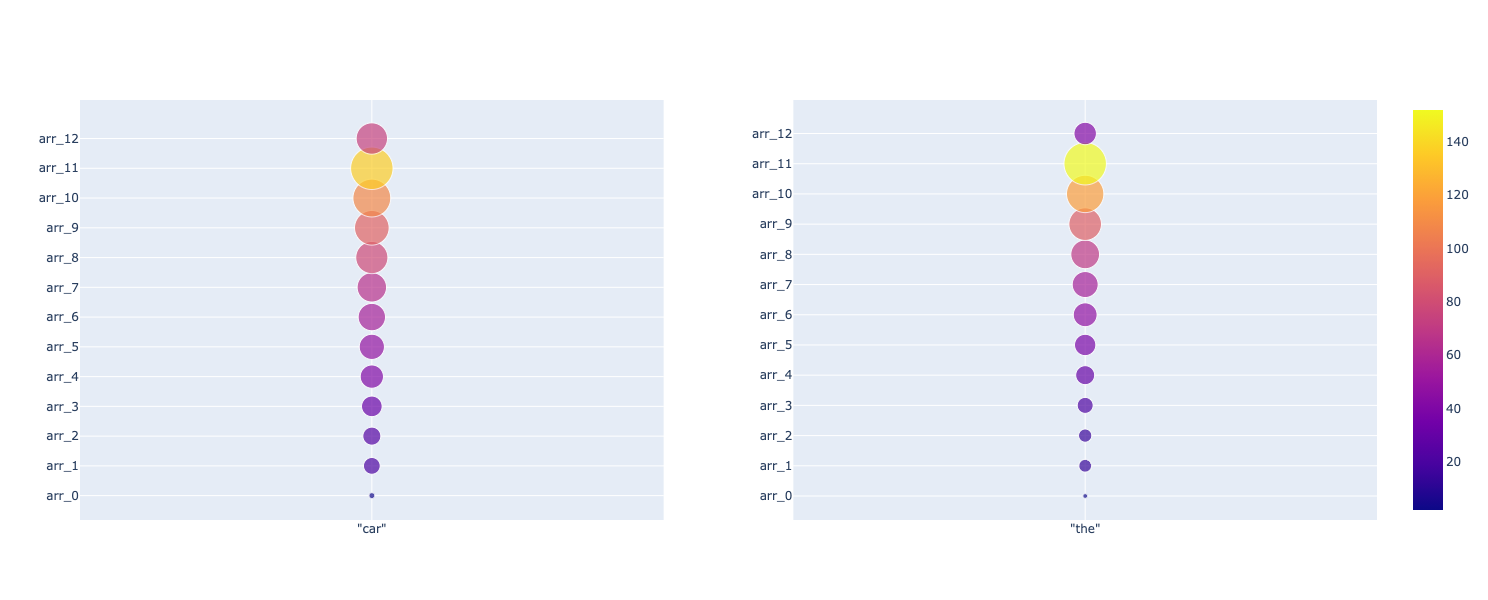

In [44]:
# vis

# names = ['car','the',]
# fig = make_subplots(rows=1, cols=len(names))
# for i, name in enumerate(names):
#     fig.append_trace(px.scatter(data_frame=sizes[sizes['space']==f'\"{name}\"'], x='space', y='layer', size='area', color='area', size_max=30,
#                            color_continuous_scale=px.colors.sequential.Rainbow)['data'][0], row=1, col=i+1)

px.scatter(data_frame=sizes[sizes['space']==f'\"{name}\"'], x='space', y='layer', size='area', color='area', size_max=30,
                           color_continuous_scale=px.colors.sequential.Rainbow, facet)
fig.update_layout(autosize=False, height=600, width=300*len(names), xaxis_title=None)

In [ ]:
# vis
fig = make_subplots(rows=1, cols=2)

fig.add_trace(px.scatter(data_frame=sizes[sizes['space']=='\"car\"'], x='space', y='layer', size='area', color='area', size_max=10), row=1, col=1)
fig.add_trace(px.scatter(data_frame=sizes[sizes['space']=='\"car\"'], x='space', y='layer', size='area', color='area', size_max=10,
            color_continuous_scale=px.colors.sequential.Rainbow, title=f'Area'), row=1, col=2)

fig.update_layout(autosize=False, height=500, width=300, xaxis_title=None)

## Does layer 0 help with identity? 

In [212]:
filter_name = '## toks'
all_scores[(all_scores['predicting']==filter_name) & (all_scores['gap']==0)]

,layer,gap,score,predicting
3,arr_0,0,0.918033,## toks
10,arr_1,0,0.918033,## toks
17,arr_2,0,0.918033,## toks
24,arr_3,0,0.918033,## toks
31,arr_4,0,0.918033,## toks
38,arr_5,0,0.918033,## toks
45,arr_6,0,0.918033,## toks
52,arr_7,0,0.918033,## toks
59,arr_8,0,0.918033,## toks
66,arr_9,0,0.918033,## toks


In [34]:
all_scores = all_scores.append(probe_identity({'first and last layers': np.hstack([corpus_acts[layers[0]], corpus_acts[layers[-1]]])}, 
                                              corpus_contexts, filters[filter_name], filter_name=filter_name, gaps=[0]))

arr_0 ...0 ...


,layer,gap,score,predicting
0,arr_0,0,0.976959,## toks
